In [1]:
#!pip install -q datasets transformers opencv-python torch torchvision

In [2]:
import random
import torch
import numpy as np
# Set random seed for PyTorch
torch.manual_seed(42)
# Set random seed for NumPy
np.random.seed(42)
# Set random seed for Python's random module
random.seed(42)

In [3]:
from datasets import load_dataset 

# Load dataset
dataset = load_dataset('flowers_new')
print(dataset)

Resolving data files:   0%|          | 0/7840 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1681 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1680 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/matthew/.cache/huggingface/datasets/imagefolder/flowers_new-5b642d1ef98c51ca/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7840
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1681
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1680
    })
})


In [4]:
print(dataset["train"].features['label'].names)

['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulip']


In [5]:
labels = dataset["train"].features["label"].names
num_labels = len(dataset["train"].features["label"].names)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'bellflower': 0, 'daisy': 1, 'dandelion': 2, 'lotus': 3, 'rose': 4, 'sunflower': 5, 'tulip': 6}
{0: 'bellflower', 1: 'daisy', 2: 'dandelion', 3: 'lotus', 4: 'rose', 5: 'sunflower', 6: 'tulip'}


In [6]:
import torch
import torch.nn as nn

# Create toy image with dim (batch x channel x width x height)
toy_img = torch.rand(1, 3, 48, 48)

# Define conv layer parameters
num_channels = 3
hidden_size = 768 #or emb_dimension
patch_size = 16

# Conv 2D layer
projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size, 
             stride=patch_size)

# Forward pass toy img
out_projection = projection(toy_img)

print(f'Original image size: {toy_img.size()}')
print(f'Size after projection: {out_projection.size()}')

Original image size: torch.Size([1, 3, 48, 48])
Size after projection: torch.Size([1, 768, 3, 3])


In [7]:
# Flatten the output after projection with Conv2D layer

patch_embeddings = out_projection.flatten(2).transpose(1, 2)
print(f'Patch embedding size: {patch_embeddings.size()}')

Patch embedding size: torch.Size([1, 9, 768])


In [8]:
# Define [CLS] token embedding with the same emb dimension as the patches
batch_size = 1
cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
cls_tokens = cls_token.expand(batch_size, -1, -1)

# Prepend [CLS] token in the beginning of patch embedding
patch_embeddings = torch.cat((cls_tokens, patch_embeddings), dim=1)
print(f'Patch embedding size: {patch_embeddings.size()}')

Patch embedding size: torch.Size([1, 10, 768])


In [9]:
# Define position embedding with the same dimension as the patch embedding
position_embeddings = nn.Parameter(torch.randn(batch_size, 10, hidden_size))

# Add position embedding into patch embedding
input_embeddings = patch_embeddings + position_embeddings
print(f'Input embedding size: {input_embeddings.size()}')

Input embedding size: torch.Size([1, 10, 768])


In [10]:
# Define parameters for ViT-base (example)
num_heads = 12
num_layers = 12

# Define Transformer encoders' stack
transformer_encoder_layer = nn.TransformerEncoderLayer(
           d_model=hidden_size, nhead=num_heads,
           dim_feedforward=int(hidden_size * 4),
           dropout=0.1)
transformer_encoder = nn.TransformerEncoder(
           encoder_layer=transformer_encoder_layer,
           num_layers=num_layers)

# Forward pass
output_embeddings = transformer_encoder(input_embeddings)
print(f' Output embedding size: {output_embeddings.size()}')

 Output embedding size: torch.Size([1, 10, 768])


In [11]:
from transformers import ViTModel

# Load pretrained model
model_checkpoint = 'google/vit-base-patch16-224-in21k'
model = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)

# Example input image
input_img = torch.rand(batch_size, num_channels, 224, 224)

# Forward pass input image
output_embedding = model(input_img)
print(output_embedding)
print(f"Ouput embedding size: {output_embedding['last_hidden_state'].size()}")

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 0.0624, -0.2346,  0.1001,  ...,  0.2118,  0.0678, -0.3426],
         [ 0.2469, -0.0026,  0.1923,  ...,  0.0094,  0.1464, -0.3206],
         [-0.0831, -0.2880,  0.0914,  ...,  0.0013,  0.2357, -0.3663],
         ...,
         [-0.1517, -0.2491, -0.0454,  ...,  0.0760,  0.0587, -0.3484],
         [-0.0449, -0.1906,  0.0146,  ...,  0.1221,  0.0863, -0.4513],
         [ 0.1433, -0.0777,  0.0025,  ..., -0.0215,  0.0337, -0.3343]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=None, hidden_states=None, attentions=None)
Ouput embedding size: torch.Size([1, 197, 768])


In [12]:
num_labels = 7

# Define linear classifier layer
classifier = nn.Linear(hidden_size, num_labels) 

# Forward pass on the output embedding of [CLS] token
output_classification = classifier(output_embedding['last_hidden_state'][:, 0, :])
print(f"Output embedding size: {output_classification.size()}")

Output embedding size: torch.Size([1, 7])


In [13]:
import numpy as np
import torch
import cv2
import torch.nn as nn
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

#Pretrained model checkpoint
model_checkpoint = 'google/vit-base-patch16-224-in21k'

In [14]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_data):

        self.input_data = input_data
        # Transform input data
        self.transform = transforms.Compose([
        transforms.Resize((224, 224), antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                             std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.input_data)

    def get_images(self, idx):
        return self.transform(self.input_data[idx]['image'])

    def get_labels(self, idx):
        return self.input_data[idx]['label']

    def __getitem__(self, idx):
        # Get input data in a batch
        train_images = self.get_images(idx)
        train_labels = self.get_labels(idx)

        return train_images, train_labels

In [15]:
class ViT(nn.Module):

    def __init__(self, config=ViTConfig(), num_labels=7, 
               model_checkpoint='google/vit-base-patch16-224-in21k'):

        super(ViT, self).__init__()

        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.classifier = (
            nn.Linear(config.hidden_size, num_labels) 
        )

    def forward(self, x):

        x = self.vit(x)['last_hidden_state']
        # Use the embedding of [CLS] token
        output = self.classifier(x[:, 0, :])

        return output

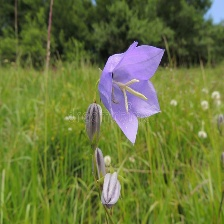

In [16]:
dataset['train'][900]['image']

In [17]:
import time
def model_train(dataset, epochs, learning_rate, bs):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load nodel, loss function, and optimizer
    model = ViT().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Load batch image
    train_dataset = ImageDataset(dataset['train'])
    train_dataloader = DataLoader(train_dataset, num_workers=1, batch_size=bs, shuffle=True)
    # Load batch image
    val_dataset = ImageDataset(dataset['validation'])
    val_dataloader = DataLoader(val_dataset, num_workers=1, batch_size=bs, shuffle=True)

    # Fine tuning loop
    min_loss = np.inf
    val_losses = []
    train_losses = []
    val_accs = []
    train_accs = []
    for i in range(epochs):
        total_acc_train = 0
        total_loss_train = 0.0
        total_acc_val = 0
        total_loss_val = 0.0

        for train_image, train_label in tqdm(train_dataloader):
            output = model(train_image.to(device))
            loss = criterion(output, train_label.to(device))
            acc = (output.argmax(dim=1) == train_label.to(device)).sum().item()
            total_acc_train += acc
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()
        for val_image, val_label in val_dataloader:
            output = model(val_image.to(device))
            val_loss = criterion(output, val_label.to(device))
            val_acc = (output.argmax(dim=1) == val_label.to(device)).sum().item()
            total_acc_val += val_acc
            total_loss_val += val_loss.item()

        if total_loss_val < min_loss:
            min_loss = total_loss_val
            torch.save(model, 'vit_model.pth')
        print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(train_dataset): .3f} | Accuracy: {total_acc_train / len(train_dataset): .3f}')
        print(f'Epochs: {i + 1} | Val Loss: {total_loss_val / len(val_dataset): .3f} | Accuracy: {total_acc_val / len(val_dataset): .3f}')
        val_losses.append(total_loss_val / len(val_dataset))
        train_losses.append(total_loss_train / len(train_dataset))
        val_accs.append(total_acc_val / len(val_dataset))
        train_accs.append(total_acc_train / len(train_dataset))      
        
    return train_losses, val_losses, train_accs, val_accs

# Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
tic = time.time()
# Train the model
train_losses, val_losses, train_accs, val_accs = model_train(dataset, EPOCHS, LEARNING_RATE, BATCH_SIZE)
toc = time.time()
print(abs(toc-tic))

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████| 245/245 [02:21<00:00,  1.74it/s]


Epochs: 1 | Loss:  0.012 | Accuracy:  0.896
Epochs: 1 | Val Loss:  0.009 | Accuracy:  0.919


100%|███████████████████████████████████████████████████████████| 245/245 [02:20<00:00,  1.74it/s]


Epochs: 2 | Loss:  0.006 | Accuracy:  0.937
Epochs: 2 | Val Loss:  0.010 | Accuracy:  0.906


100%|███████████████████████████████████████████████████████████| 245/245 [02:20<00:00,  1.74it/s]


Epochs: 3 | Loss:  0.005 | Accuracy:  0.947
Epochs: 3 | Val Loss:  0.008 | Accuracy:  0.915


100%|███████████████████████████████████████████████████████████| 245/245 [02:20<00:00,  1.74it/s]


Epochs: 4 | Loss:  0.004 | Accuracy:  0.966
Epochs: 4 | Val Loss:  0.012 | Accuracy:  0.897


100%|███████████████████████████████████████████████████████████| 245/245 [02:20<00:00,  1.74it/s]


Epochs: 5 | Loss:  0.004 | Accuracy:  0.956
Epochs: 5 | Val Loss:  0.008 | Accuracy:  0.924


100%|███████████████████████████████████████████████████████████| 245/245 [02:20<00:00,  1.74it/s]


Epochs: 6 | Loss:  0.004 | Accuracy:  0.963
Epochs: 6 | Val Loss:  0.009 | Accuracy:  0.920


100%|███████████████████████████████████████████████████████████| 245/245 [02:20<00:00,  1.74it/s]


Epochs: 7 | Loss:  0.003 | Accuracy:  0.972
Epochs: 7 | Val Loss:  0.009 | Accuracy:  0.915


100%|███████████████████████████████████████████████████████████| 245/245 [02:20<00:00,  1.74it/s]


Epochs: 8 | Loss:  0.002 | Accuracy:  0.976
Epochs: 8 | Val Loss:  0.008 | Accuracy:  0.919


100%|███████████████████████████████████████████████████████████| 245/245 [02:20<00:00,  1.74it/s]


Epochs: 9 | Loss:  0.002 | Accuracy:  0.978
Epochs: 9 | Val Loss:  0.009 | Accuracy:  0.926


100%|███████████████████████████████████████████████████████████| 245/245 [02:20<00:00,  1.74it/s]


Epochs: 10 | Loss:  0.003 | Accuracy:  0.971
Epochs: 10 | Val Loss:  0.008 | Accuracy:  0.932
1522.2396564483643


# Model Prediction

In [18]:
trained_model = torch.load('vit_model.pth')

In [19]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                             std=[0.5, 0.5, 0.5])
        ])
    
    img = transform(img)
    output = trained_model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

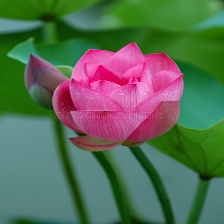

In [20]:
dataset['test'][900]['image']

In [21]:
print(predict(dataset['test'][900]['image']))

lotus


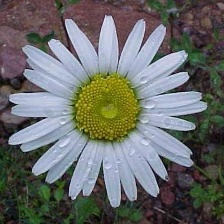

In [22]:
dataset['test'][250]['image']

In [23]:
print(predict(dataset['test'][250]['image']))

daisy


In [24]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
criterion = nn.CrossEntropyLoss().to(device)

# Load batch image
test_dataset = ImageDataset(dataset['test'])
test_loader = DataLoader(test_dataset, num_workers=1, batch_size=32)

trained_model.eval()  # Switch to evaluation mode
total_acc_test = 0
total_loss_test= 0.0
with torch.no_grad():
    model.eval()
    for test_image, test_label in test_loader:
        output = trained_model(test_image.to(device))
        test_loss = criterion(output, test_label.to(device))
        test_acc = (output.argmax(dim=1) == test_label.to(device)).sum().item()
        total_acc_test += test_acc
        total_loss_test += test_loss.item()


accuracy = 100 * (total_acc_test/ len(test_dataset))
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 92.50%


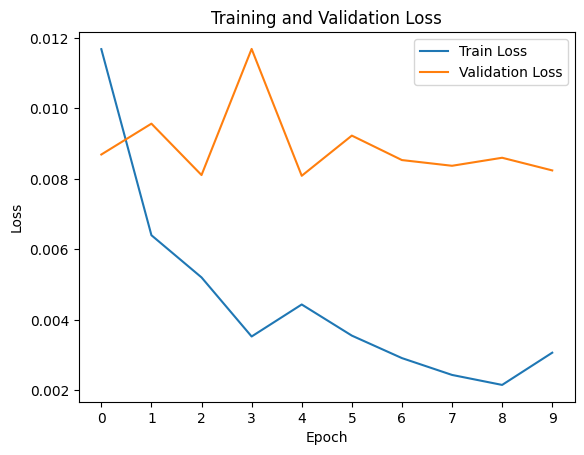

In [25]:
import matplotlib.pyplot as plt

# Example losses data
epoch = np.arange(len(train_losses))

# Plot losses
plt.plot(epoch, train_losses, label='Train Loss')
plt.plot(epoch, val_losses, label='Validation Loss')
plt.xticks(range(min(epoch), max(epoch)+1, 1), map(int, range(min(epoch), max(epoch)+1, 1)))


# Set labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Add legend
plt.legend()

# Display the plot
plt.show()



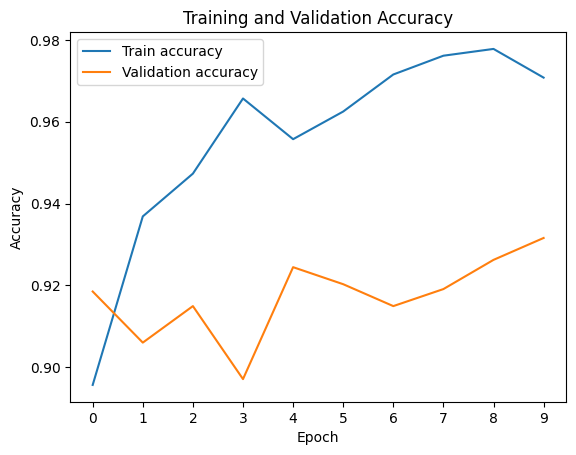

In [26]:
# Example losses data
epoch = np.arange(len(train_accs))

# Plot accs
plt.plot(epoch, train_accs, label='Train accuracy')
plt.plot(epoch, val_accs, label='Validation accuracy')
plt.xticks(range(min(epoch), max(epoch)+1, 1), map(int, range(min(epoch), max(epoch)+1, 1)))

# Set labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')


# Add legend
plt.legend()

# Display the plot
plt.show()
